In [3]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax import grad, jit, vmap
import optax
from jax.experimental import sparse

import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time

from src.plots import plot_multiples

In [4]:
# black theme
rng = random.PRNGKey(0)
plt.style.use('dark_background')
eras = [2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-10-25 17:22:00.873912: W pjrt_plugin/src/mps_client.cc:534] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [145]:
def load_data(scale=1):
    with rio.open('data/tmp/prodes_brasil_2021.tif') as src:
        raw = src.read(1)[::scale, ::scale]
        meta = src.meta
    return raw

def process_data(raw: jnp.ndarray) -> jnp.ndarray:
    raw_reshaped = raw[:, None, :, :]  # Add an extra dimension for eras
    eras_reshaped = jnp.array(eras)[:, None, None]  # Add two extra dimensions for area_size
    data = (raw_reshaped == eras_reshaped).astype(jnp.float32)
    data = data[:, :, :, :, None]
    return data

def get_batches(data, rng, batch_size=16, area_size=512, oversample_factor=1):
    mask = data[::128, ::128] != 255
    X, Y = np.meshgrid(np.arange(0, area_size), np.arange(0, area_size))
    x_domain, y_domain = np.where(mask)
    while True:
        idx = np.random.choice(len(x_domain), size=batch_size * oversample_factor, replace=False)
        x_coords, y_coords = x_domain[idx] * 112, y_domain[idx] * 112
        X_shifted, Y_shifted = X + x_coords[:, None, None], Y + y_coords[:, None, None]
        batch = data[X_shifted, Y_shifted]
        batch = process_data(batch)
        batch = batch[batch.max(axis=(1, 2, 3, 4)) == 1]
        batch = batch.transpose(1, 0, 2, 3, 4)
        yield batch

In [146]:
data = load_data() if 'data' not in globals() else eval('data')
batches = get_batches(data, rng)


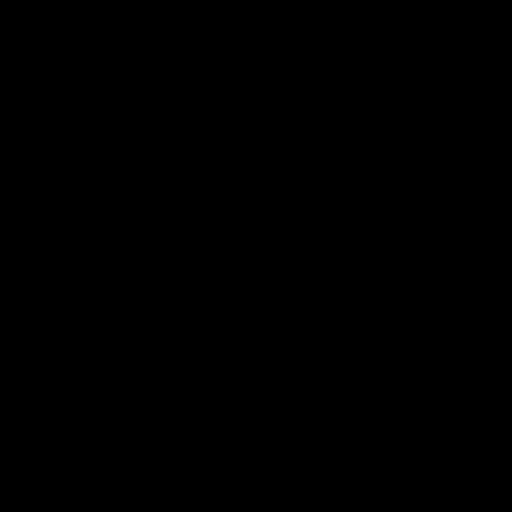
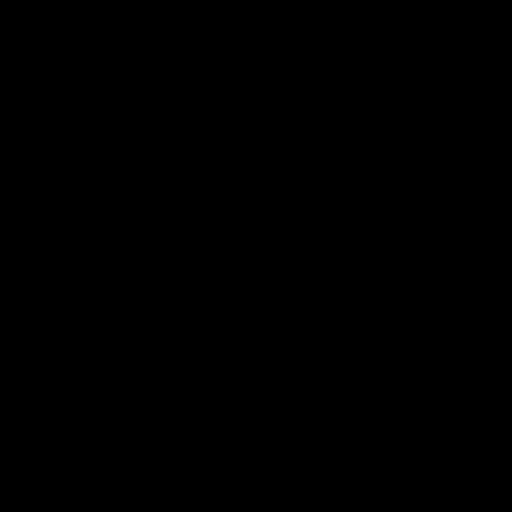
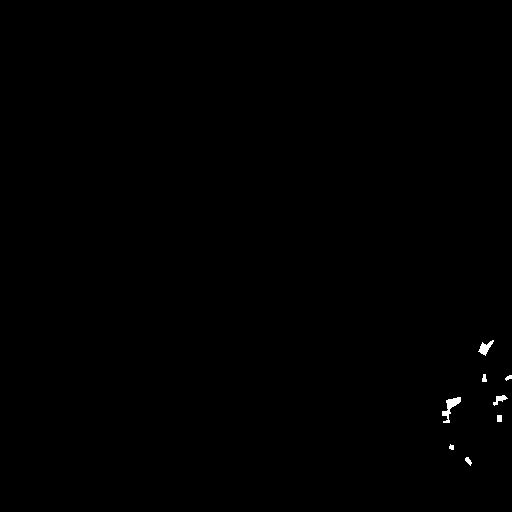
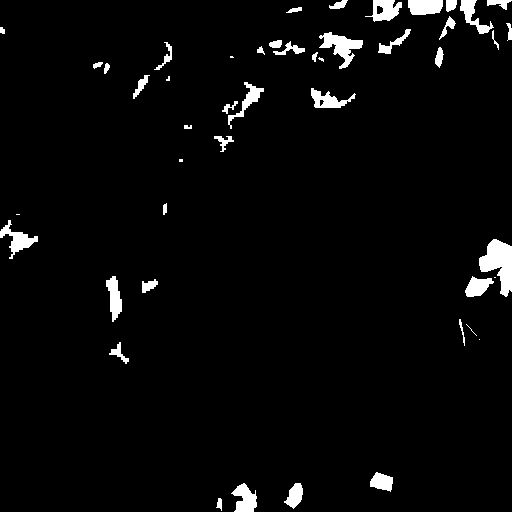
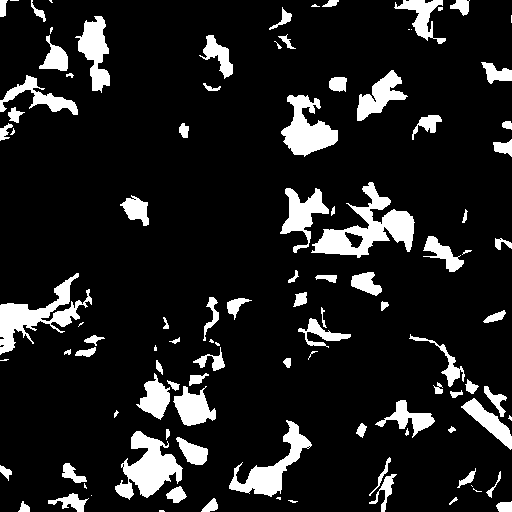
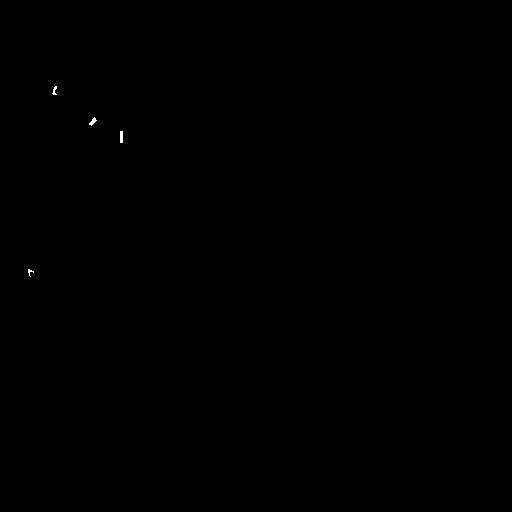
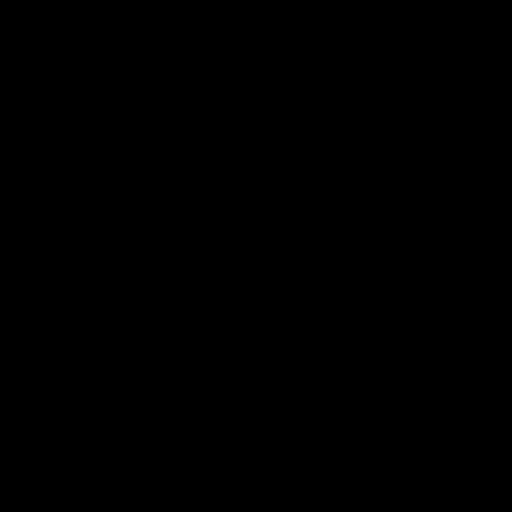
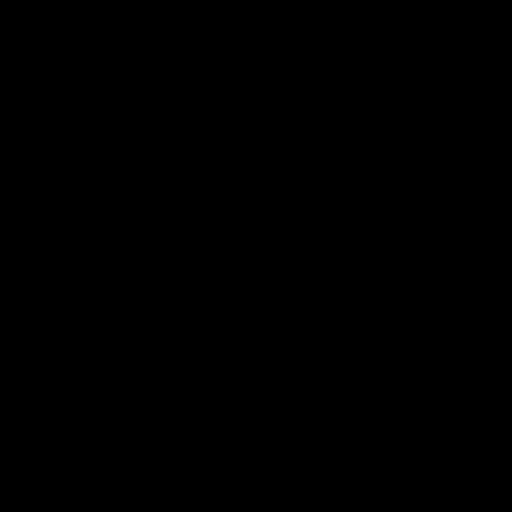

In [147]:
for step in range(100):
    batch = next(batches)
    for i, era in enumerate(batch):
        plot_multiples(era, 8)

In [ ]:
@jit
def conv2d(x, w):
    return jax.lax.conv_general_dilated(
        x, w, 
        window_strides=(2, 2), 
        padding='SAME',
        dimension_numbers=("NHWC", "HWIO", "NHWC"))

def upscale_nearest_neighbor(x, scale_factor=2):
    # Assuming x has shape (batch, height, width, channels)
    b, h, w, c = x.shape
    x = x.reshape(b, h, 1, w, 1, c)
    x = lax.tie_in(x, jnp.broadcast_to(x, (b, h, scale_factor, w, scale_factor, c)))
    return x.reshape(b, h * scale_factor, w * scale_factor, c)

def deconv2d(x, w):
    x_upscaled = upscale_nearest_neighbor(x)
    return lax.conv_transpose(
        x_upscaled, w, 
        strides=(1, 1), 
        padding='SAME',
        dimension_numbers=("NHWC", "HWIO", "NHWC")) 


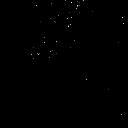
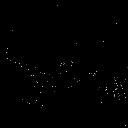
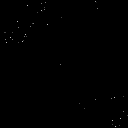
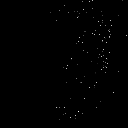
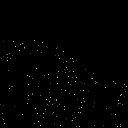
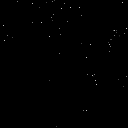
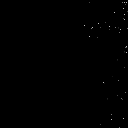
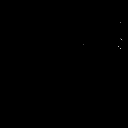

KeyboardInterrupt: 

In [ ]:
batch = next(batches)
params = random.normal(rng, (3, 3, 1, 1))
for era in batch:
    plot_multiples(conv2d(era, params), 8)
    time.sleep(1)